In [253]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from diffusers import DDPMScheduler


In [254]:
# Target distribution $q_D$
N = 1000
Xs = np.random.randn(2 * N).reshape(N, 2)
Xs[:, 1] -= 2 * Xs[:, 0] ** 2
# Normalize data to zero mean, unit variance
Xs = (Xs - np.mean(Xs, axis=0).reshape(1, -1)) / np.std(Xs, axis=0).reshape(1, -1)

# Assert that the data is normalized
assert np.allclose(np.mean(Xs, axis=0), 0)
assert np.allclose(np.std(Xs, axis=0), 1)


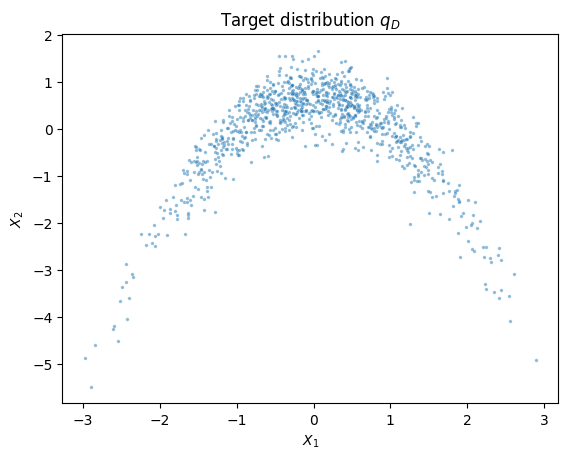

In [270]:
plt.figure()
sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], alpha=0.5, s=6)
plt.title(r"Target distribution $q_D$")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

In [255]:
# neural network to learn epsilon(x_t,t)
class Net(nn.Module):
    def __init__(self, num_latent_features=32, num_embedding_features=16):
        super().__init__()
        self.num_embedding_features = num_embedding_features
        self.num_latent_features = num_latent_features
        self.fc_in = nn.Linear(2, num_latent_features)
        self.fc_emb = nn.Linear(num_embedding_features, num_latent_features)
        self.fc1 = nn.Linear(num_latent_features, num_latent_features)
        self.fc2 = nn.Linear(num_latent_features, num_latent_features)
        self.fc_out = nn.Linear(num_latent_features, 2)

    def embedding(self, t):
        num_frequencies = self.num_embedding_features // 2
        frequencies = torch.logspace(
            0, 3, num_frequencies, device=t.device, dtype=t.dtype
        )
        cos_feats = torch.cos(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        sin_feats = torch.sin(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        return torch.hstack([cos_feats, sin_feats])

    def forward(self, x, t):
        t_embedding = torch.nn.functional.silu(self.embedding(t))
        x = F.silu(self.fc_in(x) + self.fc_emb(t_embedding))
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = self.fc_out(x)
        return x


In [256]:
def generate_betas(method, T=100, cap=0.999):
    """
    Generate betas for the diffusion process.

    Args:
        method (str): Method to generate betas. One of "uniform", "linear", "cosine_cap".
        T (int): Number of betas to generate.

    "uniform": Uniform betas of 0.05.
    "linear": Linearly spaces betas from 1e-4 to 0.02.
    "cosine_cap": Cosine decaying with a cap of 0.995.

    Returns:
        torch.Tensor: Betas.
    """
    if method == "uniform":
        return 0.05 * torch.ones(T, dtype=torch.float32)
    elif method == "linear":
        beta_start = 1e-4
        beta_end = 0.02
        betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
        betas = torch.tensor(betas)
        return betas
    elif method == "cosine_cap":

        def alpha_bar_fn(t):
            return np.cos((t + 0.008) / 1.008 * np.pi / 2.0) ** 2

        betas = []
        for i in range(T):
            t1 = i / T
            t2 = (i + 1) / T
            betas.append(min(1 - alpha_bar_fn(t2) / alpha_bar_fn(t1), 0.9))
        return torch.tensor(betas, dtype=torch.float32)


In [257]:
# Total diffusion steps
T = 100
# Define betas
beta_schedule = "cosine_cap"
betas = generate_betas(beta_schedule, T=T, cap=0.9)


In [258]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=T, beta_schedule="squaredcos_cap_v2"
)
# noise_scheduler.alphas

In [259]:
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat(
    (torch.tensor([1.0], dtype=torch.float32), alphas_cumprod), dim=0
)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)


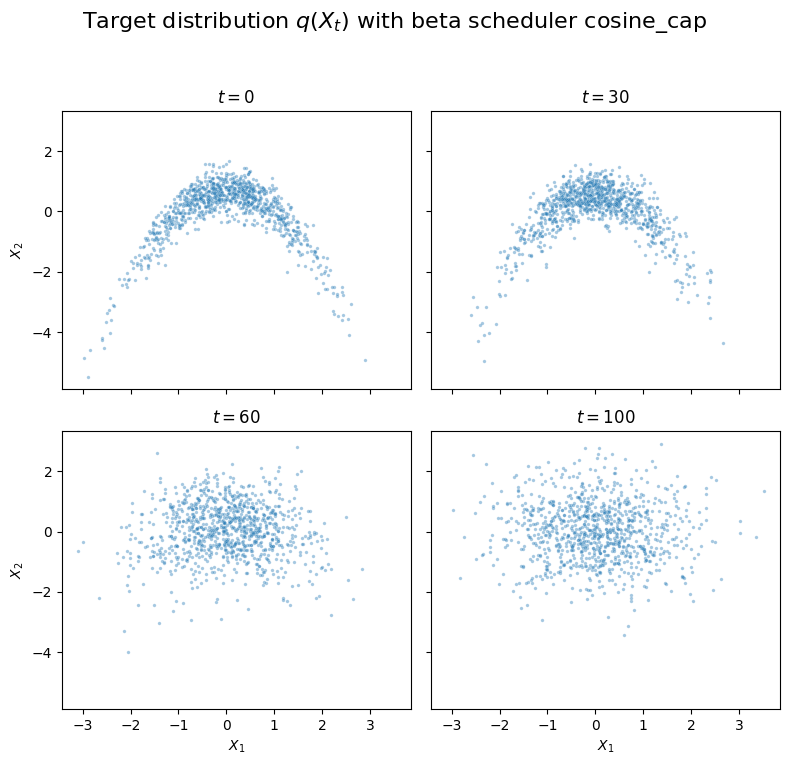

In [260]:
X_0 = Xs
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()
ts = [0, 30, 60, 100]

for idx, t in enumerate(ts):
    X_t = np.random.normal(
        loc=np.sqrt(alphas_cumprod_prev[t]) * X_0,
        scale=1.0 - alphas_cumprod_prev[t],
        size=(N, 2),
    )
    ax = axes[idx]
    sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], ax=ax, alpha=0.4, s=6)
    ax.set_title(f"$t={t}$")
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")

fig.suptitle(
    r"Target distribution $q(X_t)$ with beta scheduler " + beta_schedule, fontsize=16
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"./figures/target_distribution_{beta_schedule}.png", dpi=600)
plt.show()


In [261]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)

betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
alphas_cumprod_prev = alphas_cumprod_prev.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
sqrt_recip_alphas = sqrt_recip_alphas.to(device)

x_start = torch.tensor(Xs, dtype=torch.float32).to(device)

batch_size = 10
num_epochs = 500

dataset = torch.utils.data.TensorDataset(x_start)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [262]:
def loss_fn(Xs, model):
    batch_size_curr = Xs.size(0)
    t = torch.randint(0, T, (batch_size_curr,), device=device).long()
    epsilon = torch.randn_like(Xs).to(device)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].reshape(-1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1)

    x_t = sqrt_alphas_cumprod_t * Xs + sqrt_one_minus_alphas_cumprod_t * epsilon

    t_normalized = t.float() / T

    epsilon_theta = model(x_t, t_normalized)

    loss = F.mse_loss(epsilon_theta, epsilon)
    return loss

In [263]:
losses = []
for epoch in tqdm.trange(num_epochs):
    for batch in dataloader:
        Xr = batch[0].to(device)
        loss = loss_fn(Xr, model)
        losses.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 500/500 [00:18<00:00, 27.09it/s]


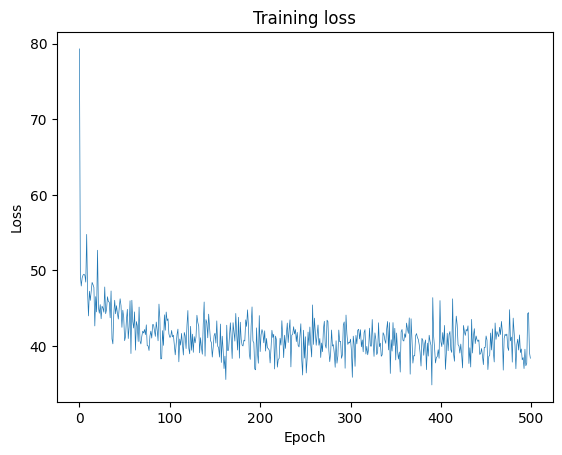

In [276]:
sns.lineplot(
    x=range(num_epochs),
    y=np.array(losses).reshape(num_epochs, -1).sum(axis=1),
    linewidth=0.5,
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.savefig("./figures/diffusion_loss.png", dpi=600)

plt.show()

In [265]:
# Sampling
def p_sample(model, x, t):
    t_tensor = torch.full((x.size(0),), t, device=device, dtype=torch.long)
    t_normalized = t_tensor.float() / T
    epsilon_theta = model(x, t_normalized)
    beta_t = betas[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
    sqrt_recip_alphas_t = sqrt_recip_alphas[t]
    x_prev = sqrt_recip_alphas_t * (
        x - (beta_t / sqrt_one_minus_alphas_cumprod_t) * epsilon_theta
    )
    if t > 0:
        noise = torch.randn_like(x)
        sigma_t = torch.sqrt(beta_t)
        x_prev = x_prev + sigma_t * noise
    return x_prev


In [266]:
def sample(model, num_samples):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 2).to(device)
        for t in reversed(range(T)):
            x = p_sample(model, x, t)
    return x.cpu().numpy()


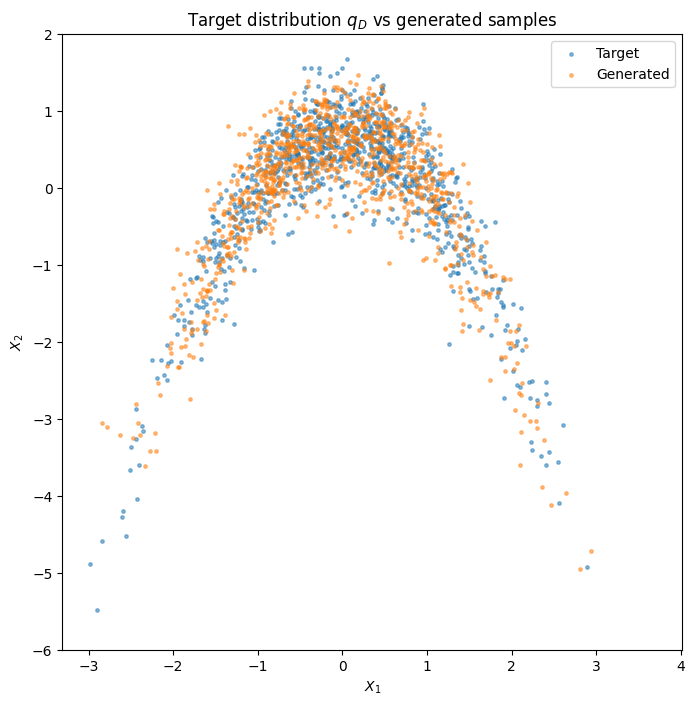

In [274]:
samples = sample(model, N)

plt.figure(figsize=(8, 8))
plt.scatter(Xs[:, 0], Xs[:, 1], alpha=0.5, s=6, label="Target")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=6, label="Generated")
plt.title(r"Target distribution $q_D$ vs generated samples")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.ylim(-6, 2)
plt.legend()
plt.show()
